<a href="https://colab.research.google.com/github/git-lab205/python/blob/master/ml_models_best_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd, numpy as np, seaborn as sns
import os
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize']=(10, 6)
path = '/content'

In [ ]:
movies_path = os.path.join(path, 'movies.csv')

In [ ]:
movies = pd.read_csv(movies_path, sep=';')

In [ ]:
movies

,Movie,Budget,Box office
0,Властелин колец: Две крепости,94,937
1,Гарри Поттер и Дары Смерти. Часть 2,125,1342
2,Форсаж 7,190,1516
3,Мир юрского периода,150,1672
4,Звёздные войны: Пробуждение силы,200,2068
5,Аватар,246,2834


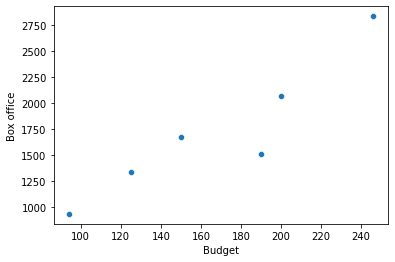

In [ ]:
sns.scatterplot(x="Budget", y="Box office", data=movies)

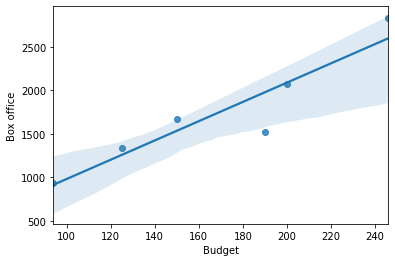

In [ ]:
sns.regplot(x="Budget", y="Box office", data=movies)

In [ ]:
!pip install -U scikit-learn

     |████████████████████████████████| 22.3 MB 4.8 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


# Задача прогнозирования стоимости бриллиантов (задача регрессии) с Kaggle

In [ ]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
import lightgbm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
# Загружаем датасет, смотим на количество строк
df = pd.read_csv(os.path.join(path, 'diamonds_moded.csv'), sep=';')
df.shape

(53940, 10)

price - price in US dollars (\$326--\$18,823)

carat - weight of the diamond (0.2--5.01)

cut - quality of the cut (Fair, Good, Very Good, Premium, Ideal)

color - diamond colour, from J (worst) to D (best)

clarity - a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

x - length in mm (0--10.74)

y - width in mm (0--58.9)

z - depth in mm (0--31.8)

depth - total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)

table - width of top of diamond relative to widest point (43--95)

In [ ]:
# Смотрим на часть данных
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,NaN,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## Подготовка данных:
### - Проверить адекватность колонок (нельзя использовать данные, которые нам будут недоступны в production)
### - Обработать пропуски в данных (модели обычно не принимают пропуски в данных)
### - Перевести категориальные значения в численные (модели обычно не принимают категориальные данные)
<br>

In [ ]:
# Проверим наличие пропусков в данных
df.isna().sum()

carat       0
cut         0
color      10
clarity     0
depth       0
table       0
price       0
x           0
y           0
z           0
dtype: int64

In [ ]:
# Пропусков мало - заполним их модой
df['color'].fillna(df['color'].mode()[0], inplace=True)

# Тоже самое можно сделать при помощи SimpleImputer из scikit-learn

In [ ]:
# Убедимся, что пропусков больше нет
df.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [ ]:
# Находим категориальные колонки и используем LabelEncoder для перевода в численные значения
cat_columns = [cname for cname in df.columns if df[cname].dtype == "object"]
encoder = preprocessing.LabelEncoder()

for col in cat_columns:
    df[col] = encoder.fit_transform(df[col])

# Альтернатива - One Hot Encoder

In [ ]:
df

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,2,1,3,61.5,55.0,326,3.95,3.98,2.43
1,0.21,3,3,2,59.8,61.0,326,3.89,3.84,2.31
2,0.23,1,1,4,56.9,65.0,327,4.05,4.07,2.31
3,0.29,3,5,5,62.4,58.0,334,4.20,4.23,2.63
4,0.31,1,6,3,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,2,0,2,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,1,0,2,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,4,0,2,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,3,4,3,61.0,58.0,2757,6.15,6.12,3.74


In [ ]:
# Делим датасет на X и Y, затем выделяем часть для валидации
X = df.drop('price', axis=1)
y = df['price']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1)

## Обучение Baseline моделей

In [ ]:
### Linear Regression ###

lr = LinearRegression()
scores = cross_val_score(lr, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print('Linear Regression cross validation MAE:', - np.mean(scores))

Linear Regression cross validation MAE: 864.645727899958


In [ ]:
### Decision Tree ###

dt = DecisionTreeRegressor() # Задача регрессии - подгружаем Regressor
scores = cross_val_score(dt, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print('Decision Tree cross validation MAE:', - np.mean(scores))

Decision Tree cross validation MAE: 370.2471975389045


In [ ]:
### Random Forest ###

rf = RandomForestRegressor(random_state=0)
scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print('Random Forest cross validation MAE:', - np.mean(scores))

Random Forest cross validation MAE: 277.43261557752004


In [ ]:
##### LightGBM #####

lgb = lightgbm.LGBMRegressor(random_state=0)
scores = cross_val_score(lgb, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print('Cross validation MAE:', - np.mean(scores))

Cross validation MAE: 288.3530635899607


## Подбор параметров и окончательный выбор модели

In [ ]:
def cv_params(model, param_grid):
    scoring = 'neg_mean_absolute_error'

    opt_params = GridSearchCV(
        estimator=model,          # Модель
        param_grid=param_grid,    # Параметры
        scoring=scoring,          # Стратегия валидации
        cv=5,                     # Количество слоев кросс валидации
        n_jobs=-1)                # Количество потоков для обучения, -1 = все

    opt_params.fit(X_train, y_train)
    params = opt_params.best_params_
    best_score = opt_params.best_score_

    print(f'Best score: {round(-best_score, 2)}')
    print(f'Best parameters: {params}\n')

    return params

In [ ]:
##### LightGBM #####
lgb_param_grid = {
                'max_depth': [4, 10, 15, -1],               # Максимальная глубина дерева
                'num_leaves': [25, 35, 45],                 # Максимальное кол-во листьев на дереве
                'n_estimators': [41, 100, 250, 500, 600]    # Количетсво деревьев
                }

lgb_clean = lightgbm.LGBMRegressor(random_state=1)
lgb_params = cv_params(lgb_clean, lgb_param_grid)

Best score: 273.66
Best parameters: {'max_depth': 10, 'n_estimators': 500, 'num_leaves': 45}



In [ ]:
##### Random Forest #####
rf_param_grid = {
                'max_depth': [20, 25],
                'n_estimators': [500, 800]
                }

rf_clean = RandomForestRegressor(random_state=1)
rf_params = cv_params(rf_clean, rf_param_grid)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best score: 276.0
Best parameters: {'max_depth': 20, 'n_estimators': 800}



### Итоговая модель - LightGBM

In [ ]:
# Обучаем на лучших параметрах, смотрим MAPE
lgb = lightgbm.LGBMRegressor(**lgb_params)
lgb.fit(X_train, y_train)

preds = lgb.predict(X_valid)

print(f'MAPE: {round(mean_absolute_percentage_error(y_valid, preds) * 100, 2)}%')
print(f'MAE: {round(mean_absolute_error(y_valid, preds), 2)}')

MAPE: 6.67%
MAE: 263.97


In [ ]:
# Смотрим на примеры прогноза модели
results = pd.DataFrame({'Model': np.round(preds), 'Actual': y_valid})
results = results.reset_index().drop('index', axis=1)
results.head(15)

,Model,Actual
0,508.0,564
1,5598.0,5914
2,2575.0,2562
3,547.0,537
4,5877.0,5964
5,1276.0,984
6,4988.0,5247
7,627.0,611
8,10771.0,9645
9,1071.0,1162


In [ ]:
# Обучаем на всех данных
lgb.fit(X, y)

LGBMRegressor(max_depth=10, n_estimators=500, num_leaves=45)